In [1]:
!python -V

Python 3.9.12


In [2]:
import pandas as pd

In [3]:
import pickle

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [6]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("taxi-01")

2025/06/23 19:08:07 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/06/23 19:08:07 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


<Experiment: artifact_location='/workspaces/mlops_practice/02-experiment-tracking/mlruns/1', creation_time=1750704701115, experiment_id='1', last_update_time=1750704701115, lifecycle_stage='active', name='taxi-01', tags={}>

In [7]:
df = pd.read_parquet('../data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [8]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

9.775464552087287

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


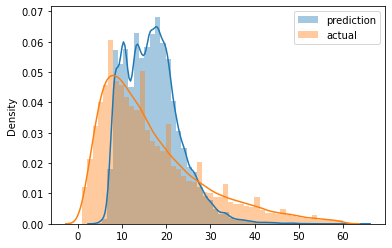

In [9]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [10]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [11]:
df_train = read_dataframe('../data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('../data/green_tripdata_2021-02.parquet')

In [12]:
len(df_train), len(df_val)

(73908, 61921)

In [13]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [14]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [15]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [16]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.479562160810692

In [17]:
with open('../models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [19]:
with mlflow.start_run():

    mlflow.set_tag("developer","evan")
    mlflow.log_param("train-data-path","../data/green_tripdata_2021-01.parquet")
    mlflow.log_param("val-data-path","../data/green_tripdata_2021-02.parquet")
        
    alpha = 0.001
    mlflow.log_param("alpha", alpha)

    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

In [23]:
import xgboost as xgb

In [21]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [24]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [25]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [26]:


search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)



  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:11:44] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.98020                          
[1]	validation-rmse:9.99979                           
[2]	validation-rmse:9.22737                           
[3]	validation-rmse:8.62589                           
[4]	validation-rmse:8.16087                           
[5]	validation-rmse:7.80584                           
[6]	validation-rmse:7.53415                           
[7]	validation-rmse:7.32734                           
[8]	validation-rmse:7.16968                           
[9]	validation-rmse:7.05054                           
[10]	validation-rmse:6.95724                          
[11]	validation-rmse:6.88515                          
[12]	validation-rmse:6.82951                          
[13]	validation-rmse:6.78656                          
[14]	validation-rmse:6.75279                          
[15]	validation-rmse:6.72540                          
[16]	validation-rmse:6.70338                          
[17]	validation-rmse:6.68545                          
[18]	valid

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:15:38] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.59281                                                      
[1]	validation-rmse:9.41900                                                       
[2]	validation-rmse:8.58472                                                       
[3]	validation-rmse:8.00312                                                       
[4]	validation-rmse:7.60072                                                       
[5]	validation-rmse:7.32495                                                       
[6]	validation-rmse:7.13726                                                       
[7]	validation-rmse:7.00892                                                       
[8]	validation-rmse:6.92092                                                       
[9]	validation-rmse:6.85343                                                       
[10]	validation-rmse:6.80639                                                      
[11]	validation-rmse:6.77188                                                      
[12]

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:18:39] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.49817                                                       
[1]	validation-rmse:7.22557                                                       
[2]	validation-rmse:6.81928                                                       
[3]	validation-rmse:6.67194                                                       
[4]	validation-rmse:6.61403                                                       
[5]	validation-rmse:6.58197                                                       
[6]	validation-rmse:6.56306                                                       
[7]	validation-rmse:6.55129                                                       
[8]	validation-rmse:6.54094                                                       
[9]	validation-rmse:6.53786                                                       
[10]	validation-rmse:6.53507                                                      
[11]	validation-rmse:6.53217                                                      
[12]

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:19:37] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.64711                                                     
[1]	validation-rmse:6.62291                                                     
[2]	validation-rmse:6.60003                                                     
[3]	validation-rmse:6.59103                                                     
[4]	validation-rmse:6.58589                                                     
[5]	validation-rmse:6.57747                                                     
[6]	validation-rmse:6.56687                                                     
[7]	validation-rmse:6.56106                                                     
[8]	validation-rmse:6.55116                                                     
[9]	validation-rmse:6.54452                                                     
[10]	validation-rmse:6.53717                                                    
[11]	validation-rmse:6.52982                                                    
[12]	validation-rmse:6.52642

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:20:05] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.53966                                                      
[1]	validation-rmse:8.11306                                                      
[2]	validation-rmse:7.39328                                                      
[3]	validation-rmse:7.03855                                                      
[4]	validation-rmse:6.85602                                                      
[5]	validation-rmse:6.76071                                                      
[6]	validation-rmse:6.70323                                                      
[7]	validation-rmse:6.66954                                                      
[8]	validation-rmse:6.64844                                                      
[9]	validation-rmse:6.63484                                                      
[10]	validation-rmse:6.62181                                                     
[11]	validation-rmse:6.61405                                                     
[12]	validation-

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:21:47] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.70211                                                     
[1]	validation-rmse:11.23246                                                     
[2]	validation-rmse:10.80227                                                     
[3]	validation-rmse:10.40814                                                     
[4]	validation-rmse:10.04905                                                     
[5]	validation-rmse:9.72074                                                      
[6]	validation-rmse:9.42117                                                      
[7]	validation-rmse:9.14767                                                      
[8]	validation-rmse:8.89992                                                      
[9]	validation-rmse:8.67513                                                      
[10]	validation-rmse:8.47141                                                     
[11]	validation-rmse:8.28747                                                     
[12]	validation-

KeyboardInterrupt: 

In [27]:
mlflow.xgboost.autolog(disable=True)

In [29]:


with mlflow.start_run():
    
    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)

    best_params = {
        'learning_rate': 0.09585355369315604,
        'max_depth': 30,
        'min_child_weight': 1.060597050922164,
        'objective': 'reg:linear',
        'reg_alpha': 0.018060244040060163,
        'reg_lambda': 0.011658731377413597,
        'seed': 42
    }

    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )

    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    with open("../models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    mlflow.log_artifact("../models/preprocessor.b", artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")



/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:27:29] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:11.44482
[1]	validation-rmse:10.77202
[2]	validation-rmse:10.18363
[3]	validation-rmse:9.67396
[4]	validation-rmse:9.23166
[5]	validation-rmse:8.84808
[6]	validation-rmse:8.51883
[7]	validation-rmse:8.23597
[8]	validation-rmse:7.99320
[9]	validation-rmse:7.78709
[10]	validation-rmse:7.61022
[11]	validation-rmse:7.45952
[12]	validation-rmse:7.33049
[13]	validation-rmse:7.22098
[14]	validation-rmse:7.12713
[15]	validation-rmse:7.04752
[16]	validation-rmse:6.98005
[17]	validation-rmse:6.92232
[18]	validation-rmse:6.87112
[19]	validation-rmse:6.82740
[20]	validation-rmse:6.78995
[21]	validation-rmse:6.75792
[22]	validation-rmse:6.72994
[23]	validation-rmse:6.70547
[24]	validation-rmse:6.68390
[25]	validation-rmse:6.66421
[26]	validation-rmse:6.64806
[27]	validation-rmse:6.63280
[28]	validation-rmse:6.61924
[29]	validation-rmse:6.60773
[30]	validation-rmse:6.59777
[31]	validation-rmse:6.58875
[32]	validation-rmse:6.58107
[33]	validation-rmse:6.57217
[34]	validation-rmse:

2025/06/23 19:30:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:30:25] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/06/23 19:30:32 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp109_qoin/model, flavor: xgboost). Fall back to return ['xgboost==2.1.4']. Set logging level to DEBUG to see the full traceback. 
2025/06/23 19:30:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [1]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

mlflow.sklearn.autolog()

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):

    with mlflow.start_run():

        mlflow.log_param("train-data-path", "../data/green_tripdata_2021-01.csv")
        mlflow.log_param("valid-data-path", "../data/green_tripdata_2021-02.csv")
        mlflow.log_artifact("../models/preprocessor.b", artifact_path="preprocessor")

        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)
        

NameError: name 'mlflow' is not defined